# Pre-training a Masked Autoencoder with Keras

In [95]:
# !pip install -U tensorflow-addons
# !pip install tensorflow

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random

import os
import shutil
from sklearn.model_selection import train_test_split


# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

In [97]:
from mae_code import *

## Hyperparameters for pretraining

Please feel free to change the hyperparameters and check your results. The best way to
get an intuition about the architecture is to experiment with it. Our hyperparameters are
heavily inspired by the design guidelines laid out by the authors in
[the original paper](https://arxiv.org/abs/2111.06377).

In [98]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 20


## Load and prepare the Cow Images Dataset

In [99]:
# Original directory containing all images
original_data_dir = '../png_512'

# Directory where you want to store training, validation, and test images
base_dir = '../data'

# Create directories for training, validation, and test sets
os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# List of all image files in the original directory
all_files = [filename for filename in os.listdir(original_data_dir) if filename.endswith('.png')]
# Split the files into training, validation, and test sets
train_files, test_files = train_test_split(all_files, test_size=0.1, random_state=42)
train_files, validation_files = train_test_split(train_files, test_size=0.11, random_state=42)

# Function to copy files from a list to a destination directory
def copy_files(file_list, src_dir, dst_dir):
    for filename in file_list:
        src = os.path.join(src_dir, filename)
        dst = os.path.join(dst_dir, filename)
        shutil.copy(src, dst)

# Copy the files to the appropriate directories (without augmentation)
copy_files(train_files, original_data_dir, train_dir)
copy_files(validation_files, original_data_dir, validation_dir)
copy_files(test_files, original_data_dir, test_dir)

In [100]:

# Create a single dataset for all images (without classes).
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),              # Base directory
    labels='inferred',    # Infer labels from directory structure
    color_mode="grayscale",
    label_mode=None,     # Labels as integers
    image_size=(IMAGE_SIZE, IMAGE_SIZE), # Image size
    batch_size=BATCH_SIZE,         # Batch size
    shuffle=True,          # Shuffle data
    interpolation='bilinear'
)

# Create a single dataset for all images (without classes).
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),              # Base directory
    labels='inferred',    # Infer labels from directory structure
    color_mode="grayscale",
    label_mode=None,     # Labels as integers
    image_size=(IMAGE_SIZE, IMAGE_SIZE), # Image size
    batch_size=BATCH_SIZE,         # Batch size
    shuffle=True,          # Shuffle data
    interpolation='bilinear'
)

# Create a single dataset for all images (without classes).
test_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),              # Base directory
    labels='inferred',    # Infer labels from directory structure
    color_mode="grayscale",
    label_mode=None,     # Labels as integers
    image_size=(IMAGE_SIZE, IMAGE_SIZE), # Image size
    batch_size=BATCH_SIZE,         # Batch size
    shuffle=True,          # Shuffle data
    interpolation='bilinear'
)


Found 56617 files.
Found 6998 files.
Found 7069 files.


## Data augmentation

- Resizing
- Rescaling

In [101]:

def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
#             layers.RandomFlip("horizontal"),
#             layers.RandomRotation(factor=0.15),  # Rotação aleatória entre -30 e 30 graus (fator = 0.15 para 15 graus)
         layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0),
         layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model


Let's visualize the image patches.

Index selected: 14.


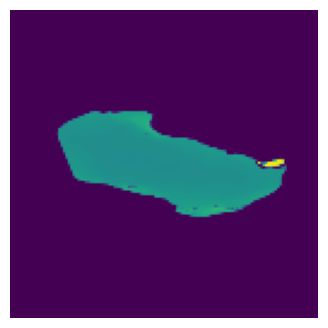

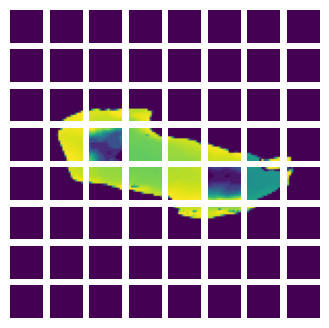

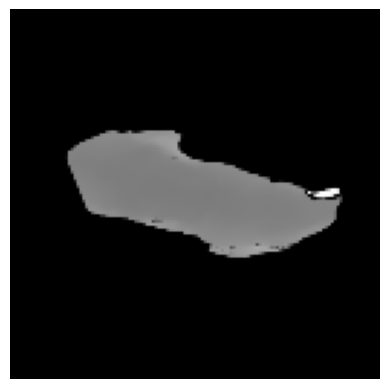

In [102]:
# Get a batch of images.
image_batch = next(iter(train_dataset))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches(channels = 1)

# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image, cmap = 'gray')
plt.axis("off")
plt.show()

Let's see the masking process in action on a sample image.

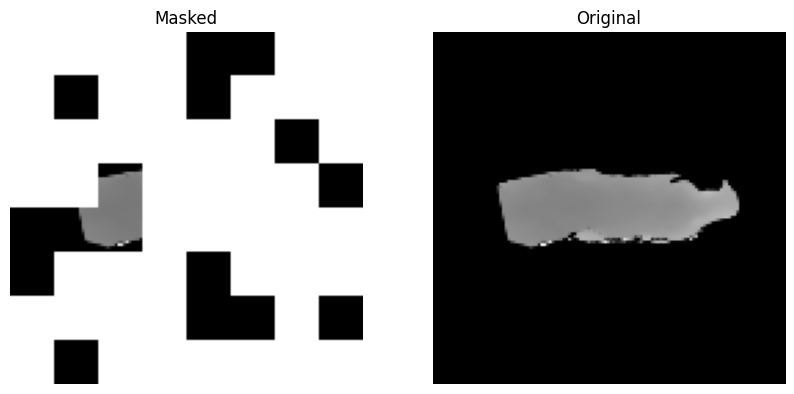

In [103]:

# Create the patch encoder layer.
patch_encoder = PatchEncoder()


# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img), cmap = 'gray')
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img), cmap = 'gray')
plt.axis("off")
plt.title("Original")
plt.show()

## Model initialization

In [104]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

## Training callbacks

### Visualization callback

In [105]:
# Taking a batch of test inputs to measure model's progress.
test_images = next(iter(test_dataset))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image, cmap = 'gray')
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image, cmap = 'gray')
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image, cmap = 'gray')
            ax[2].set_title(f"Reconstructed: {epoch:03d}")

            plt.show()
            plt.close()


### Learning rate scheduler

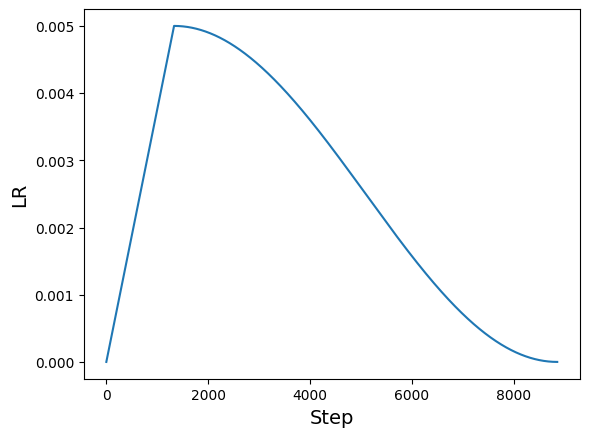

In [106]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

    def get_config(self):
        return {
            "learning_rate_base": self.learning_rate_base,
            "total_steps": self.total_steps,
            "warmup_learning_rate": self.warmup_learning_rate,
            "warmup_steps": self.warmup_steps,
        }

total_steps = int((len(train_dataset)) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]

## Model compilation and training

In [107]:
optimizer = tf.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

#Compile and pretrain the model.
mae_model.compile( optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)

Epoch 1/20


/home/alcindo/.pyenv/versions/mae-cows/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:665: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/home/alcindo/.pyenv/versions/mae-cows/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:640: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


442/443 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - mae: 0.1678 - loss: 0.2134
Idx chosen: 71


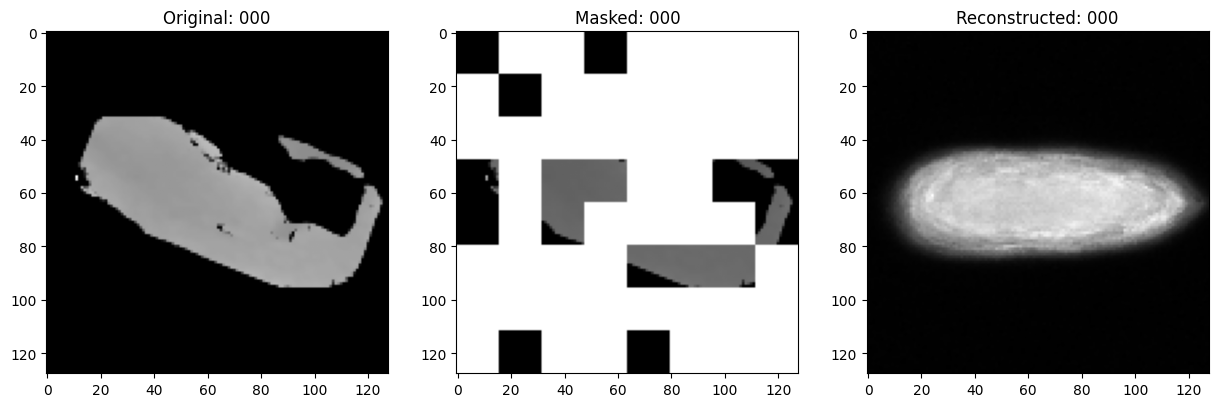

443/443 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - mae: 0.1674 - loss: 0.2130 - val_loss: 0.0839
Epoch 2/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - mae: 0.0358 - loss: 0.0836 - val_loss: 0.0822
Epoch 3/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - mae: 0.0312 - loss: 0.0826 - val_loss: 0.0893
Epoch 4/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - mae: 0.0290 - loss: 0.0825 - val_loss: 0.0821
Epoch 5/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - mae: 0.0278 - loss: 0.0824 - val_loss: 0.0886
Epoch 6/20
442/443 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - mae: 0.0268 - loss: 0.0823
Idx chosen: 60


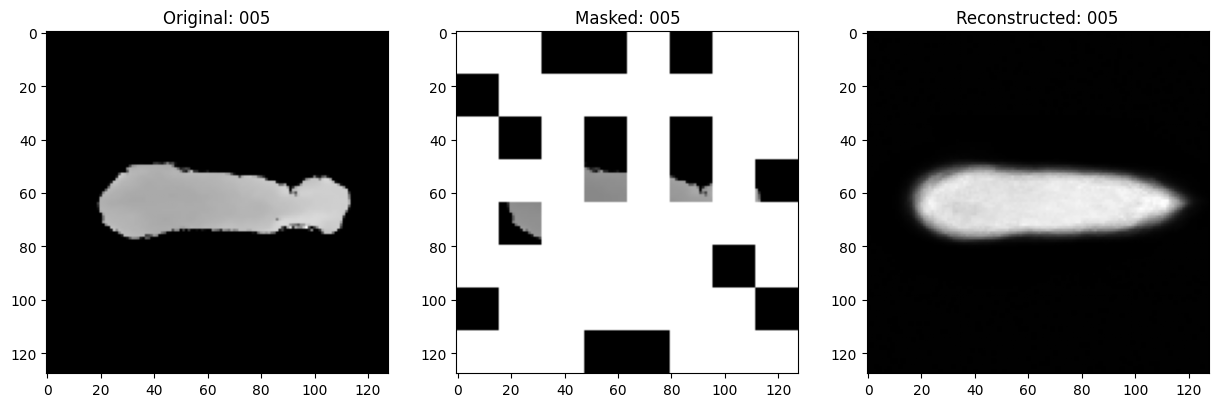

443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - mae: 0.0268 - loss: 0.0823 - val_loss: 0.0852
Epoch 7/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - mae: 0.0262 - loss: 0.0821 - val_loss: 0.0853
Epoch 8/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - mae: 0.0257 - loss: 0.0819 - val_loss: 0.0820
Epoch 9/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - mae: 0.0253 - loss: 0.0818 - val_loss: 0.0798
Epoch 10/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - mae: 0.0248 - loss: 0.0815 - val_loss: 0.0853
Epoch 11/20
442/443 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - mae: 0.0245 - loss: 0.0816
Idx chosen: 20


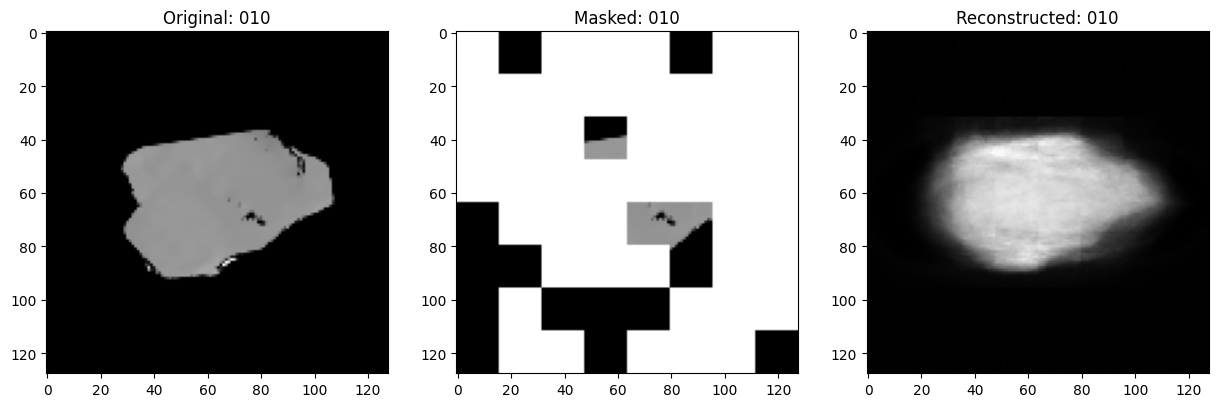

443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - mae: 0.0245 - loss: 0.0816 - val_loss: 0.0804
Epoch 12/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - mae: 0.0241 - loss: 0.0815 - val_loss: 0.0813
Epoch 13/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - mae: 0.0237 - loss: 0.0814 - val_loss: 0.0816
Epoch 14/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - mae: 0.0234 - loss: 0.0811 - val_loss: 0.0820
Epoch 15/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - mae: 0.0230 - loss: 0.0809 - val_loss: 0.0810
Epoch 16/20
442/443 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - mae: 0.0227 - loss: 0.0808
Idx chosen: 102


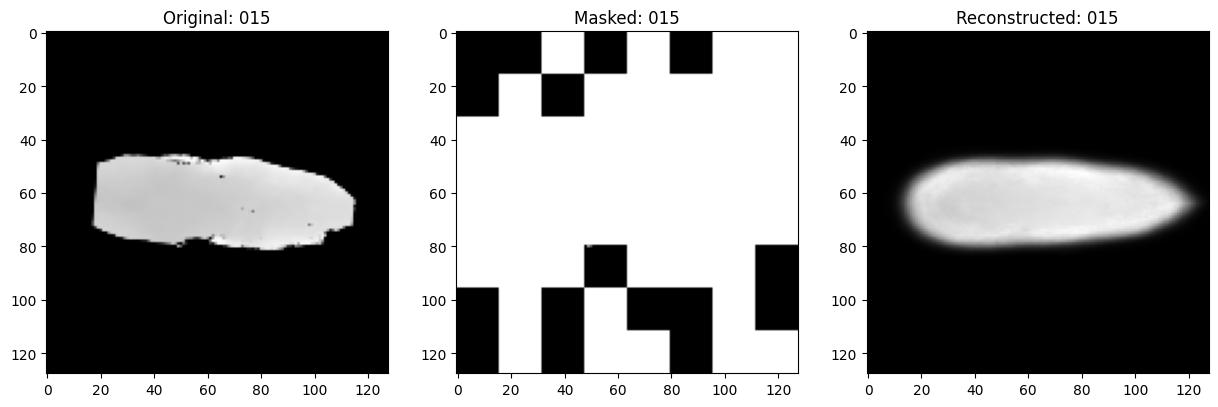

443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - mae: 0.0227 - loss: 0.0808 - val_loss: 0.0827
Epoch 17/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - mae: 0.0224 - loss: 0.0807 - val_loss: 0.0815
Epoch 18/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - mae: 0.0222 - loss: 0.0807 - val_loss: 0.0803
Epoch 19/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - mae: 0.0220 - loss: 0.0806 - val_loss: 0.0810
Epoch 20/20
443/443 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - mae: 0.0219 - loss: 0.0807 - val_loss: 0.0810


In [108]:


history = mae_model.fit(

     train_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=train_callbacks,

 )


## Saving the pre trained model

In [ ]:
import tensorflow as tf

check_point = "pre-trained-models/mp75/"

#####################
# SAVE THE COMPLETE MODEL
#####################

# Create the checkpoint for the entire model
checkpoint = tf.train.Checkpoint(
    patch_encoder=mae_model.patch_encoder,
    encoder=mae_model.encoder,
    decoder=mae_model.decoder
)

# Define the directory to save the complete model checkpoints
checkpoint_directory = check_point + 'mae_model/'

# Save the complete model
checkpoint.save(file_prefix=checkpoint_directory)


'pre-trained-models/mp75/mae_model/-1'

## Loading and Testing the Model

In [167]:
# instantiate the models



train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

optimizer = tf.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

#Compile and pretrain the model.
model.compile( optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"])

In [ ]:
import tensorflow as tf

check_point = "pre-trained-models/mp75/"

# Creating the checkpoint to restore
checkpoint = tf.train.Checkpoint(
    patch_encoder=model.patch_encoder,
    encoder=model.encoder,
    decoder=model.decoder
)

# Define the directory where the checkpoint was saved
checkpoint_directory = check_point + 'mae_model/'

# Check if the checkpoint exists and restore it
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_directory)

if latest_checkpoint:
    checkpoint.restore(latest_checkpoint).expect_partial()
    print("Checkpoint restored successfully!")
else:
    print("No checkpoint found.")


Checkpoint restaurado com sucesso!


In [169]:

import matplotlib.pyplot as plt

def visualize_results(model, augmented_images):
    # Patch the augmented images.
    patches = model.patch_layer(augmented_images)

    # Encode the patches.
    (
        unmasked_embeddings,
        masked_embeddings,
        unmasked_positions,
        mask_indices,
        unmask_indices,
    ) = model.patch_encoder(patches)

    # Pass the unmasked patches to the encoder.
    encoder_outputs = model.encoder(unmasked_embeddings)

    # Create the decoder inputs.
    encoder_outputs = encoder_outputs + unmasked_positions
    decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
    decoder_outputs = model.decoder(decoder_inputs)

    # Show a masked patch image.
    masked_patches = model.patch_encoder.generate_masked_images(
        patches[2:6], unmask_indices[2:6], color = 0.3
)

    masked_images = []
    for masked_patch in masked_patches:
        # Apply the reconstruction function to the masked patch
        masked_image = model.patch_layer.reconstruct_from_patch(masked_patch)
        masked_images.append(masked_image)

    original_image = augmented_images[2:6]
    reconstructed_image = decoder_outputs[2:6]

    # Minimalistic plot settings
    fig, ax = plt.subplots(4, 3, figsize=(7.5, 10))
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    for i in range(4):
        # Original
        ax[i, 0].imshow(original_image[i], cmap='gray')
        ax[i, 0].axis('off')

        # Masked
        ax[i, 1].imshow(masked_images[i], cmap='gray')
        ax[i, 1].axis('off')

        # Reconstruída
        ax[i, 2].imshow(reconstructed_image[i], cmap='gray')
        ax[i, 2].axis('off')

        if i == 0:
          ax[i, 0].set_title("Original")
          ax[i, 1].set_title("Masked")
          ax[i, 2].set_title("Reconstructed")

    plt.show()

In [170]:
images = next(iter(test_dataset))

augmented_images = test_augmentation_model(images)

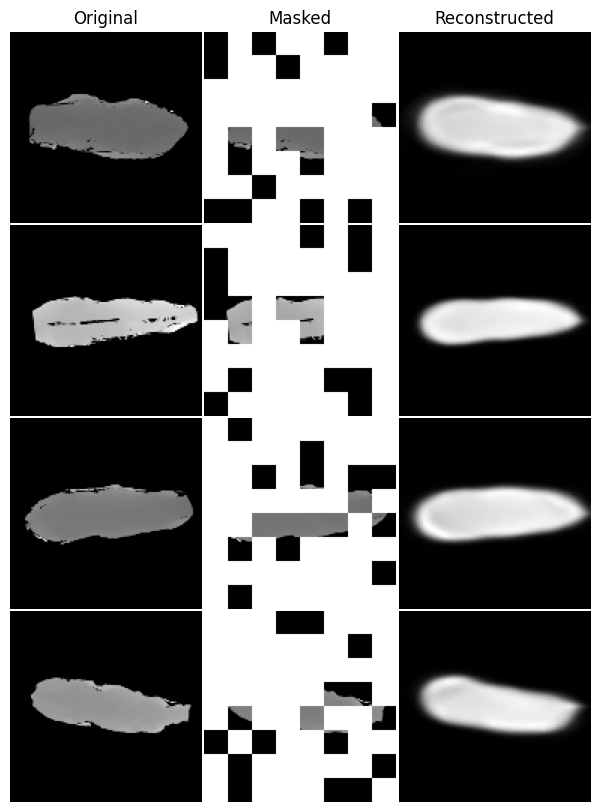

In [ ]:

visualize_results(model, augmented_images)